In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [92]:
wine = pd.read_csv("winemag-data_first150k.csv", index_col=[0])

After importing the data, I find there are duplicates to be removed.

In [93]:
wine.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [94]:
wine.sort_values('description').head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
96052,Austria,"""Chremisa,"" the ancient name of Krems, is comm...",Edition Chremisa Sandgrube 13,85,24.0,Niederösterreich,NaN,NaN,Grüner Veltliner,Winzer Krems
77587,Portugal,"""New moon on old vines” is the name of this po...",Lua Nova em Vinhas Velhas,91,15.0,Douro,NaN,NaN,Portuguese Red,Wines & Winemakers
83019,US,$10 for this very drinkable Cab? That's crazy....,NaN,87,10.0,California,North Coast,North Coast,Cabernet Sauvignon,Line 39
62345,Chile,$11. Opens with a highly perfumed bouquet of l...,Estate Reserve,84,11.0,Maipo Valley,NaN,NaN,Chardonnay,La Playa
147725,Chile,$11. Opens with a highly perfumed bouquet of l...,Estate Reserve,84,11.0,Maipo Valley,NaN,NaN,Chardonnay,La Playa


In [95]:
wine.shape

(150930, 10)

In [128]:
wine.columns[wine.isnull().any()]

Index(['country', 'designation', 'province', 'region_1', 'region_2'], dtype='object')

I also drop all rows where wine price is missing.

In [96]:
wine = wine.drop_duplicates()
wine = wine[pd.notnull(wine.price)]
wine.shape

(89131, 10)

# Exploratory analysis

## Popular wines

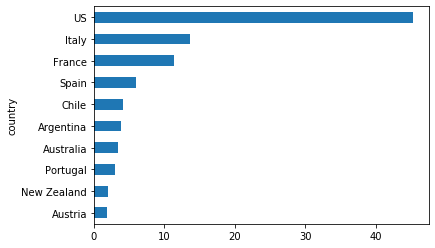

In [102]:
pop_country = wine.groupby('country')['country'].agg('count')
pop_country_pct = pop_country/wine.shape[0]*100
pop_country_pct.nlargest(10).plot(kind='barh').invert_yaxis()

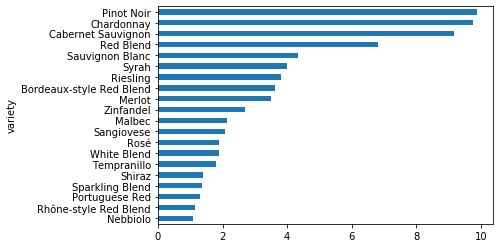

In [98]:
pop_variety = wine.groupby('variety')['price'].agg('count')
pop_variety_pct = pop_variety/wine.shape[0]*100
pop_variety_pct.nlargest(20).plot(kind='barh').invert_yaxis()

Distribution of wine review scores is almost normal.

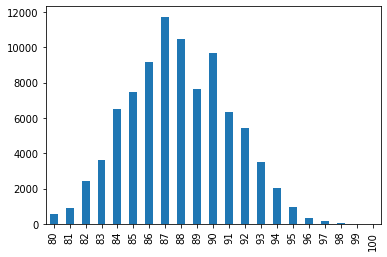

In [103]:
wine['points'].value_counts().sort_index().plot.bar()

There is a long tail of exceptionally high prices of reviewed wines.

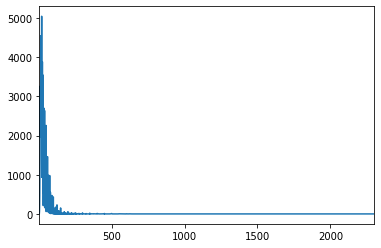

In [107]:
wine['price'].value_counts().sort_index().plot.line()

## Price vs quality

Pearson Correlation: (0.44735483119723485, 0.0)
                                 OLS Regression Results                                
Dep. Variable:                 points   R-squared (uncentered):                   0.460
Model:                            OLS   Adj. R-squared (uncentered):              0.460
Method:                 Least Squares   F-statistic:                          7.586e+04
Date:                Sun, 05 Jan 2020   Prob (F-statistic):                        0.00
Time:                        14:56:52   Log-Likelihood:                     -4.9803e+05
No. Observations:               89131   AIC:                                  9.961e+05
Df Residuals:                   89130   BIC:                                  9.961e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      

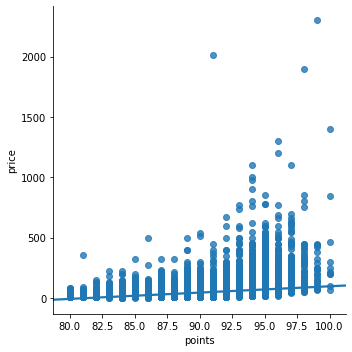

In [99]:
from scipy.stats import pearsonr
import statsmodels.api as sm
print("Pearson Correlation:", pearsonr(wine.price, wine.points))
print(sm.OLS(wine.points, wine.price).fit().summary())
sns.lmplot(y = 'price', x='points', data=wine)

What is the cheapest wine that gets a review score of 100?

In [29]:
wine[wine['points'] == 100].agg("min")["price"]

65.0

I need to select a manageable number of wine countries to analyse.

In [32]:
wine.country.value_counts()[:20]

US              40338
Italy           12152
France          10184
Spain            5370
Chile            3700
Argentina        3419
Australia        3098
Portugal         2726
New Zealand      1744
Austria          1596
Germany          1482
South Africa     1464
Greece            535
Israel            354
Canada            148
Hungary           138
Romania           106
Croatia            67
Slovenia           65
Bulgaria           56
Name: country, dtype: int64

I look at median review rating by country.

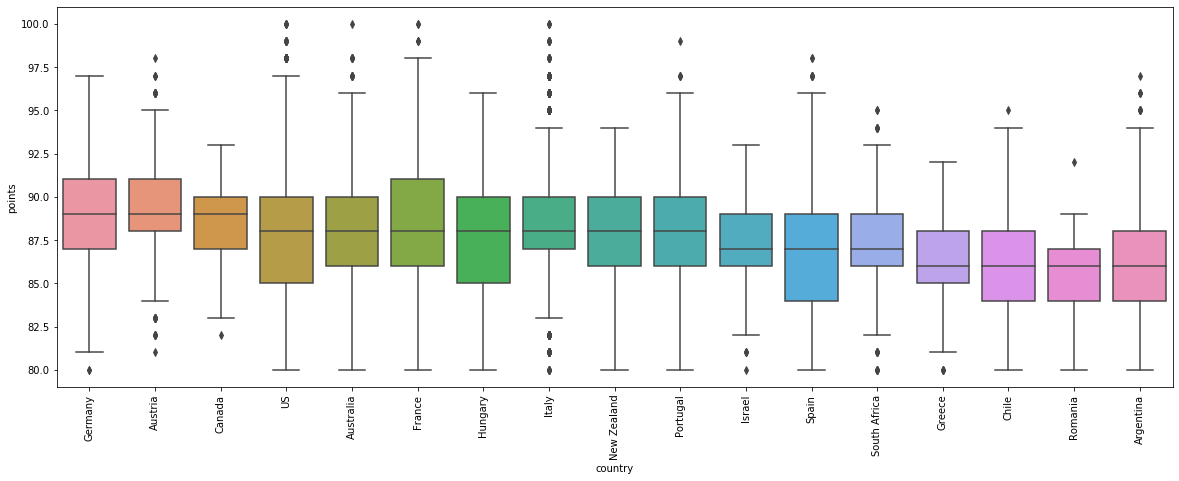

In [122]:
country=wine.groupby('country').filter(lambda x: len(x) > 100)
country_dfs = pd.DataFrame({col:vals['points'] for col,vals in country.groupby('country')})
medians = country_dfs.median()
medians.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='country',y='points', data=country, order=medians.index, ax = ax)
plt.xticks(rotation = 90)

plt.show()

I check median price of top-scoring wine countries.

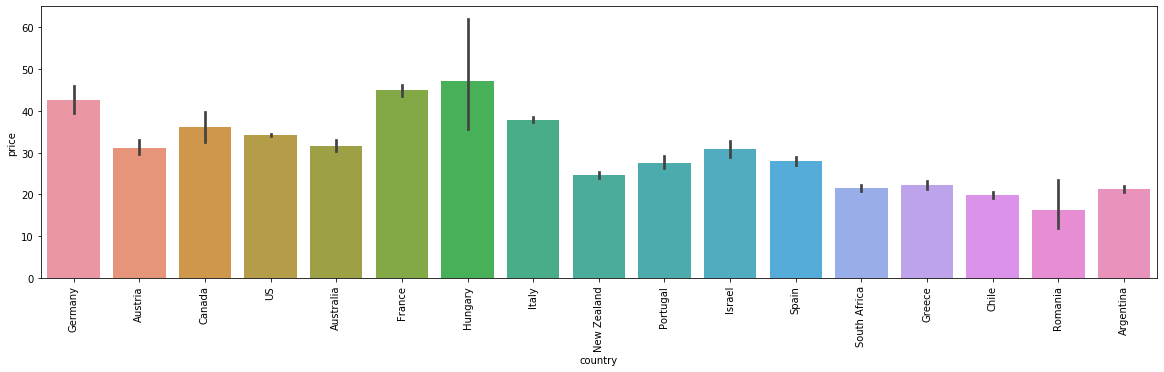

In [123]:
prices = pd.DataFrame({col:vals['price'] for col,vals in country.groupby('country')})
medians2 = prices.median()
medians2.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize = (20, 5))
chart = sns.barplot(x='country', y='price', data=country, order=medians.index, ax = ax)
plt.xticks(rotation = 90)
plt.show()

There is a large number of wine varities, but popularity is declining exponentially.

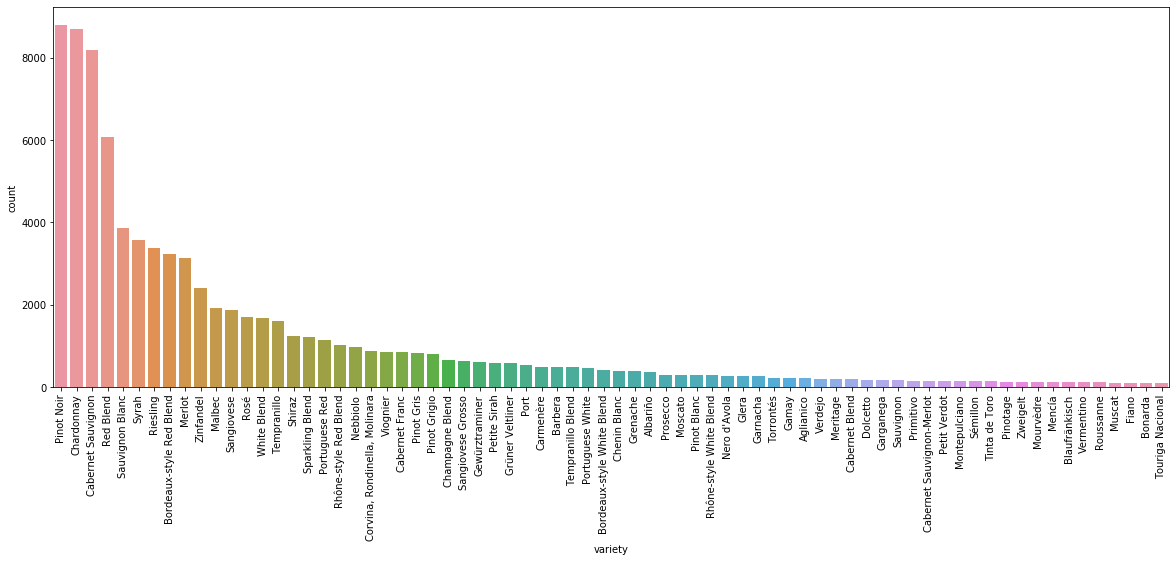

In [38]:
data = wine.groupby('variety').filter(lambda x: len(x) > 100)
list = data.variety.value_counts().index.tolist()
fig4, ax4 = plt.subplots(figsize = (20,7))
sns.countplot(x='variety', data=data, order = list, ax=ax4)
plt.xticks(rotation = 90)
plt.show()

I check median rating of varities with at least 100 observations.

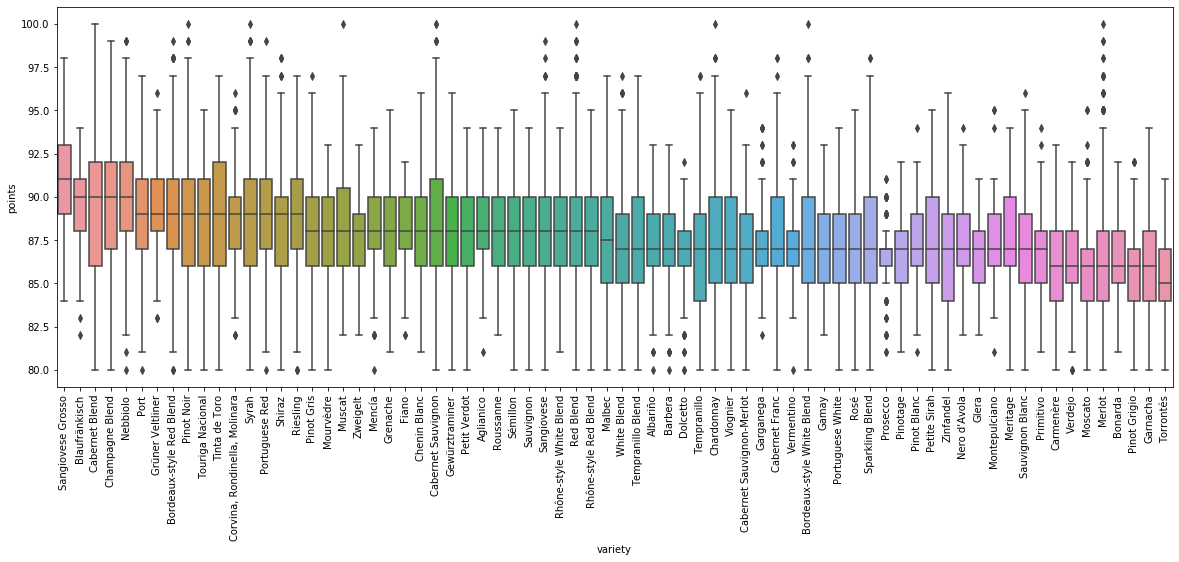

In [100]:
variety = wine.groupby('variety').filter(lambda x: len(x) > 100)
variety_dfs = pd.DataFrame({col:vals['points'] for col,vals in variety.groupby('variety')})
medians = variety_dfs.median()
medians.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='variety',y='points', data=variety, order=medians.index, ax = ax)
plt.xticks(rotation = 90)

plt.show()

I also check median ratings by wineries with at least 50 observatins.

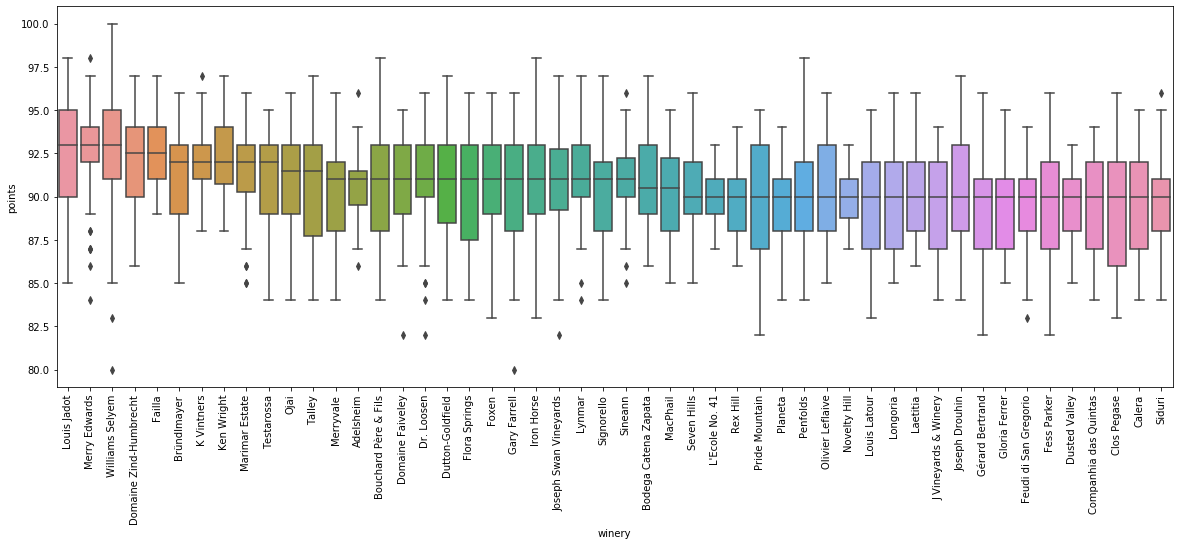

In [125]:
winery = wine.groupby('winery').filter(lambda x: len(x) > 50)
winery_dfs = pd.DataFrame({col:vals['points'] for col,vals in winery.groupby('winery')})
medians = winery_dfs.median().nlargest(50)
medians.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='winery',y='points', data=winery, order=medians.index, ax = ax)
plt.xticks(rotation = 90)

plt.show()

Mean price per variety seems to mirror median rating per variety.

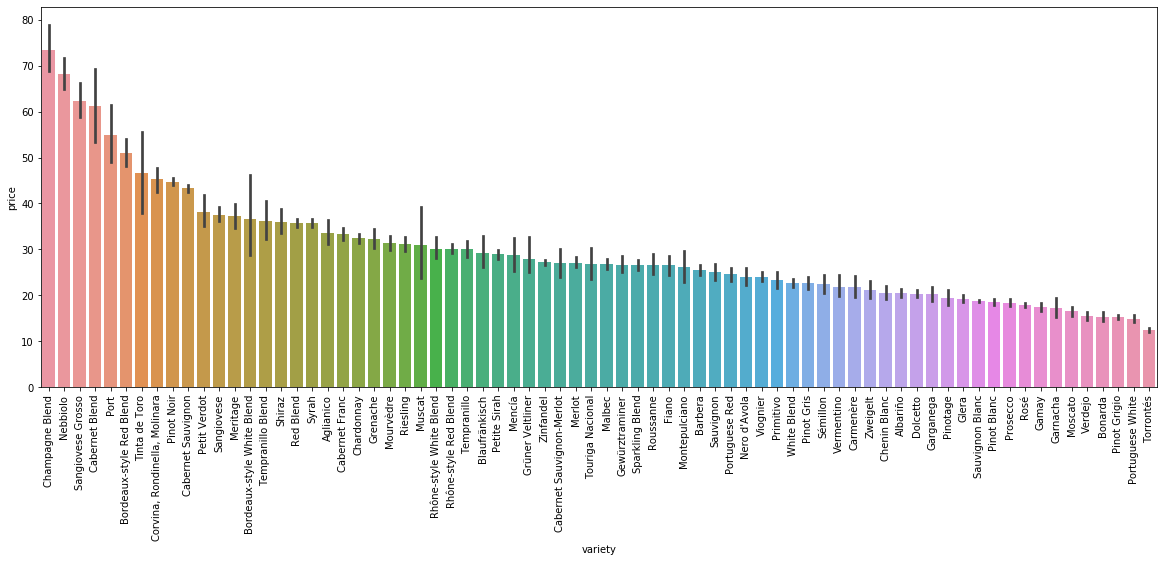

In [88]:
prices_variety = pd.DataFrame({col:vals['price'] for col,vals in variety.groupby('variety')})
means = prices_variety.mean()
means.sort_values(ascending=False, inplace=True)

fig3, ax3 = plt.subplots(figsize = (20,7))
chart = sns.barplot(x='variety',y='price', data=variety, order=means.index, ax = ax3)
plt.xticks(rotation = 90)
plt.show()

I investigate Sangiovese Grosso variety which offers an exceptionally great median rating score. 

In [61]:
print(wine[wine['variety'] == 'Sangiovese Grosso'].price.median())

55.0

In [63]:
print(wine[wine['variety'] == 'Sangiovese Grosso'].points.mean())

90.81717011128775


In [68]:
sangiovese_grosso = wine[(wine['variety'] == 'Sangiovese Grosso') & (wine['points'] > 90) & (wine['price'] < 40)]

In [74]:
sangiovese_grosso

,country,description,designation,points,price,province,region_1,region_2,variety,winery,point_per_dollar
21720,Italy,"A lovely, lush wine with bold, direct aromas o...",Casalino,93,25.0,Tuscany,Brunello di Montalcino,NaN,Sangiovese Grosso,Bonacchi,3.720000
21737,Italy,"Features sweet fruit, plum, prune and a savory...",Ugolforte,93,30.0,Tuscany,Brunello di Montalcino,NaN,Sangiovese Grosso,Tenuta San Giorgio,3.100000
22044,Italy,"Lean, compact and crisp, this Brunello is redo...",NaN,91,37.0,Tuscany,Brunello di Montalcino,NaN,Sangiovese Grosso,Tiezzi,2.459459
22161,Italy,This Rosso boasts impressively intense and pur...,NaN,91,15.0,Tuscany,Rosso di Montalcino,NaN,Sangiovese Grosso,Capanne Ricci,6.066667
22162,Italy,"Cassis, cola, leather, dried ginger, dried spi...",NaN,91,38.0,Tuscany,Brunello di Montalcino,NaN,Sangiovese Grosso,Terre Nere,2.394737
40647,Italy,Bellezza is indeed a beautiful expression of S...,Bellezza,91,35.0,Tuscany,Toscana,NaN,Sangiovese Grosso,Castello di Gabbiano,2.600000
57953,Italy,"Austere and brooding, here is a bigger style B...",NaN,92,35.0,Tuscany,Brunello di Montalcino,NaN,Sangiovese Grosso,Caprili,2.628571
57956,Italy,"Well balanced and well priced, this beautifull...",NaN,92,30.0,Tuscany,Brunello di Montalcino,NaN,Sangiovese Grosso,Le Ragnaie,3.066667
91928,Italy,Querceta delivers a beautiful Brunello with bo...,NaN,92,34.0,Tuscany,Brunello di Montalcino,NaN,Sangiovese Grosso,Querceta,2.705882
104310,Italy,Sassoalloro offers good quality for a great pr...,Sassoalloro,91,29.0,Tuscany,Toscana,NaN,Sangiovese Grosso,Jacopo Biondi-Santi,3.137931


In [79]:
sangiovese_grosso.description.iloc[3]

"This Rosso boasts impressively intense and pure Sangiovese aromas. The wine is compackt, with red berry, rum cake, dried rosemary, ginger and spice. It's a small step away from the quality of Brunello at a fraction of the price."

## Word clouds

I will check if there are differences in what words are used to describe "good" and "bad" wines.

In [143]:
good_wines = wine[wine['points'] >= 83]
bad_wines = wine[wine['points'] < 82]

In [187]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

newStopWords = [' ', 'wine', 'drink', 'now', 'flavors']

stopwords.update(newStopWords)

In [188]:
wordcloud_good = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=1500,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(good_wines['description'].astype(str)))

In [189]:
wordcloud_bad = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=1500,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(bad_wines['description'].astype(str)))

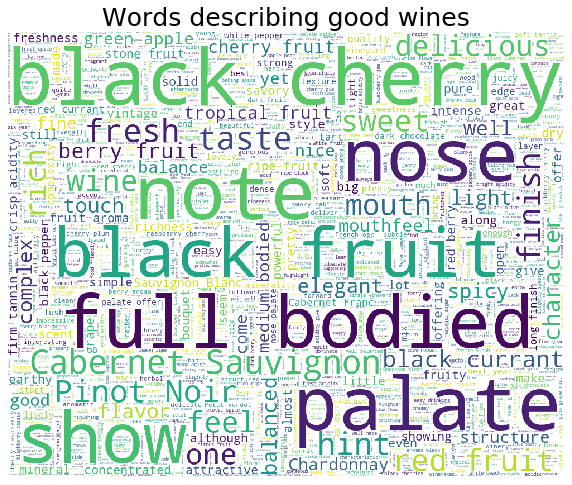

In [190]:
fig = plt.figure(figsize = (10,12))
plt.imshow(wordcloud_good)
plt.title("Words describing good wines",fontsize=25)
plt.axis('off')
plt.show()

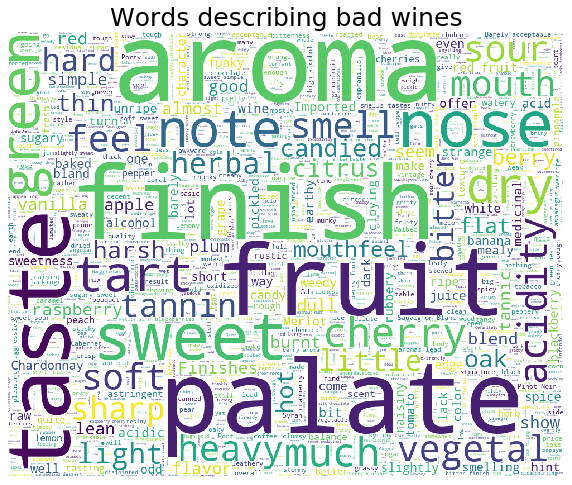

In [191]:
fig = plt.figure(figsize = (10,12))
plt.imshow(wordcloud_bad)
plt.title("Words describing bad wines",fontsize=25)
plt.axis('off')
plt.show()